# Severity Distribution of a Score: HighRiskCustomerDiscrete

In [1]:
from pyspark.sql.functions import *
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
SCORE_OUTPUT_ROOT="gs://green-1-accelerators-1-username-dpr-stg-bucket/scoring/"
FILE_PATH="Document/AdditionalOutput/HighRiskCustomerDiscrete"
STATISTICS_PATH = "Document/Statistics/Customer_CustomerScoreOutput_Merged_ScoreStatistics"
SCORE_ID_OF_INTEREST="HighRiskCustomerDiscrete"

Read in the score from the AdditionalOutput folder and the score statistics from the Customer_CustomerScoreOutput_Merged_ScoreStatistics data.

In [3]:
df = spark.read.parquet(SCORE_OUTPUT_ROOT+FILE_PATH)

In [4]:
statistics = spark.read.parquet(SCORE_OUTPUT_ROOT+STATISTICS_PATH)

Expand the customOutput column.

In [5]:
score_output = df.select("subject","customOutput.*")

In [6]:
score_output.show(5,False)

+-----------+-------------+--------+----+--------------------------------------------------+
|subject    |keys         |severity|band|description                                       |
+-----------+-------------+--------+----+--------------------------------------------------+
|10092942152|[10092942152]|20      |null|High risk customer Harry Krichauff (10092942152). |
|10910136667|[10910136667]|80      |null|High risk customer Matthew Tremper (10910136667). |
|45613094600|[45613094600]|80      |null|High risk customer Jimmy Bennett (45613094600).   |
|47583858045|[47583858045]|20      |null|High risk customer Enrique Voss (47583858045).    |
|56413973236|[56413973236]|20      |null|High risk customer Campbell Rochele (56413973236).|
+-----------+-------------+--------+----+--------------------------------------------------+
only showing top 5 rows



Get total number of customers.

In [7]:
num_cust=statistics.filter(col("scoreId")==SCORE_ID_OF_INTEREST).select("totalInputs").head()[0]

### Analysing severity distribution

Look at the number of times each severity occurs including zero severity and plot histogram.

In [19]:
categories = score_output.groupBy("severity").count()
severity_rates = categories.withColumn("trigger_rate (%)", 100*col("count")/num_cust)

In [20]:
count_triggers = statistics.filter(col("scoreId")==SCORE_ID_OF_INTEREST).select("countTriggers").head()[0]
no_triggers = num_cust-count_triggers
no_triggers_rate = 100*float(no_triggers)/num_cust

In [21]:
no_triggers_row = spark.createDataFrame([[0,no_triggers,no_triggers_rate]])
severity_rates_appended = severity_rates.union(no_triggers_row)
severity_rates_appended.orderBy("severity").show()

+--------+-----+----------------+
|severity|count|trigger_rate (%)|
+--------+-----+----------------+
|       0| 1519|           75.95|
|      20|  106|             5.3|
|      40|  136|             6.8|
|      60|  118|             5.9|
|      80|  121|            6.05|
+--------+-----+----------------+



In [41]:
severity_rates_pd = severity_rates.toPandas();

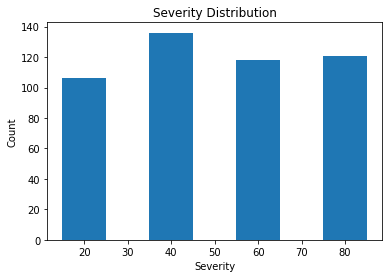

In [58]:
plt.bar(severity_rates_pd["severity"],severity_rates_pd["count"],width=10)
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

We can see that about 25% of customers trigger this score. The severities are quite evenly spread over the severity bands with 40 being the most common severity.